In [2]:
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
import torch
from torch import nn
import requests
from pathlib import Path 
import torch
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import Dataset ,DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import cluster, datasets
from sklearn.datasets import make_moons, make_circles
import sklearn.datasets
from matplotlib.axis import Axis

# # Download helper functions from Learn PyTorch repo (if not already downloaded)
# if Path("helper_functions.py").is_file():
#   print("helper_functions.py already exists, skipping download")
# else:
#   print("Downloading helper_functions.py")
#   request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
#   with open("helper_functions.py", "wb") as f:
#     f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

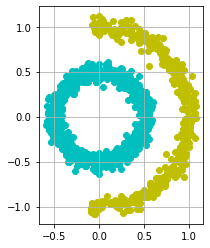

In [18]:
np.random.seed(0)
X, y = datasets.make_circles(n_samples=1500, noise = 0.05, factor = 0.5)

eps = 0.1
b = np.logical_or(X.dot(np.array([1, eps])) > 0 , X.dot(np.array([1, -eps])) >0 )
b = np.logical_and(b, y==0)
b =  np.logical_or(b, y==1)
X = X[b,:]

y = y[b]

fig, axs = plt.subplots(1,1)
axs.set_aspect('equal')

axs.scatter(X[:, 0][y==1], X[:, 1][y==1], color='c')
axs.scatter(X[:, 0][y==0],X[:, 1][y==0], color='y')

plt.grid()
plt.show()

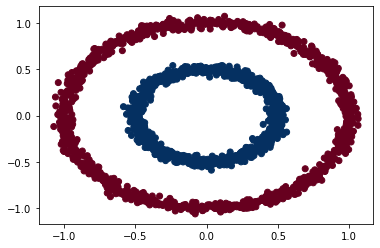

In [4]:

# n_samples = 2000

# X, y = make_circles(n_samples=2000,
#     noise=0.03,factor =0.5,
#     random_state=42,
# )

# plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu);

In [19]:

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [20]:


# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2,
                                                    random_state=42
)

X_train[:5], y_train[:5]

(tensor([[ 0.3986, -0.8759],
         [ 0.1229, -0.4784],
         [ 0.5656, -0.8718],
         [ 0.4556,  0.2478],
         [-0.4819, -0.1771]]),
 tensor([0., 1., 0., 1., 1.]))

In [21]:
# Build model with non-linear activation function

class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=3)
        self.layer_2 = nn.Linear(in_features=3, out_features=2)
        self.layer_3 = nn.Linear(in_features=2, out_features=2)
        self.layer_4 = nn.Linear(in_features=2, out_features=1)
        self.relu = nn.ReLU() # <- add in ReLU activation function
        # Can also put sigmoid in the model 
        # This would mean you don't need to use it on the predictions
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
#        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))
       return self.layer_4(self.relu(self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))))

model_3 = CircleModelV2()
print(model_3)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=3, bias=True)
  (layer_2): Linear(in_features=3, out_features=2, bias=True)
  (layer_3): Linear(in_features=2, out_features=2, bias=True)
  (layer_4): Linear(in_features=2, out_features=1, bias=True)
  (relu): ReLU()
)


In [22]:
# Setup loss and optimizer 
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [23]:
# Fit the model
torch.manual_seed(42)
epochs = 5000

# Put all data on target device
X_train, y_train = X_train, y_train
X_test, y_test = X_test, y_test

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels
    
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_3.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_3(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calcuate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.75539, Accuracy: 34.96% | Test Loss: 0.75111, Test Accuracy: 34.63%
Epoch: 100 | Loss: 0.64807, Accuracy: 65.04% | Test Loss: 0.64626, Test Accuracy: 65.37%
Epoch: 200 | Loss: 0.64722, Accuracy: 65.04% | Test Loss: 0.64520, Test Accuracy: 65.37%
Epoch: 300 | Loss: 0.64721, Accuracy: 65.04% | Test Loss: 0.64517, Test Accuracy: 65.37%
Epoch: 400 | Loss: 0.64721, Accuracy: 65.04% | Test Loss: 0.64516, Test Accuracy: 65.37%
Epoch: 500 | Loss: 0.64721, Accuracy: 65.04% | Test Loss: 0.64516, Test Accuracy: 65.37%
Epoch: 600 | Loss: 0.64721, Accuracy: 65.04% | Test Loss: 0.64516, Test Accuracy: 65.37%
Epoch: 700 | Loss: 0.64721, Accuracy: 65.04% | Test Loss: 0.64516, Test Accuracy: 65.37%
Epoch: 800 | Loss: 0.64721, Accuracy: 65.04% | Test Loss: 0.64516, Test Accuracy: 65.37%
Epoch: 900 | Loss: 0.64721, Accuracy: 65.04% | Test Loss: 0.64516, Test Accuracy: 65.37%
Epoch: 1000 | Loss: 0.64721, Accuracy: 65.04% | Test Loss: 0.64516, Test Accuracy: 65.37%
Epoch: 1100 | Loss: 0.

In [24]:
# Make predictions
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y[:10] # want preds in same format as truth labels

(tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 tensor([0., 1., 0., 1., 1., 0., 0., 1., 1., 1.]))

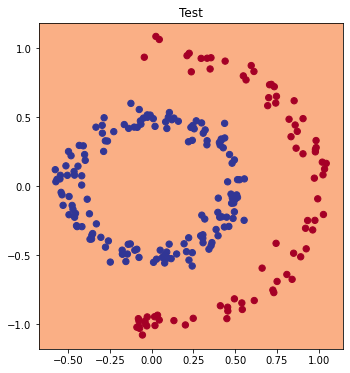

In [25]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
# plt.title("Train")
# plot_decision_boundary(model_1, X_train, y_train) # model_1 = no non-linearity
# plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity